# Airbnb Analysis into London Listings

### Business Understanding


In the following analysis we will import Airbnb's London listings and review datasets, cleanses and analyse it to figure out how much money Airbnb makes from its London listing's. Then we will model the dataset using monte-carlo simulation, to see if we can simulate the underlying distribution for listing in London.

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random
from scipy.stats import expon
from scipy.stats import gamma
from numpy import array
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import time
plotly.offline.init_notebook_mode()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})


### Data Understanding


Below we will investigate the data-sets

In [2]:
# read in the listings
listings_df = pd.read_csv("./Data/london_listings.csv")
listings_df.head()



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Stylish and bright London apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362
2,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,84,2019-04-22,0.74,1,155
3,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,40,2019-04-20,0.40,13,230
4,24328,Battersea bedroom & office w parking shared ga...,41759,Joe,NaN,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,92,2016-09-07,0.89,1,332


In [3]:
# read in the reviews
reviews_df = pd.read_csv("./Data/london_reviews.csv")
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df.head()


,listing_id,date
0,11551,2010-03-21
1,11551,2010-03-29
2,11551,2010-05-09
3,11551,2010-06-01
4,11551,2010-06-28


In [5]:
# summary stats around each dataframe
print('--------------')
print('Review shape')
print(reviews_df.shape)

print('--------------')
print('Listing shape')
print(listings_df.shape)

print('--------------')
print('NANs in reviews')
print(reviews_df.isna().sum())

print('--------------')
print('NANs in listings')
print(listings_df.isna().sum())





--------------
Review shape
(41188, 1)
--------------
Listing shape
(80767, 16)
--------------
NANs in reviews
date    0
dtype: int64
--------------
NANs in listings
id                                    0
name                                 27
host_id                               0
host_name                            49
neighbourhood_group               80767
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       20573
reviews_per_month                 20573
calculated_host_listings_count        0
availability_365                      0
dtype: int64


In [6]:
# describe review
 
print(reviews_df.describe())




               date
count  41188.000000
mean      11.349034
std       14.649154
min        1.000000
25%        2.000000
50%        6.000000
75%       14.000000
max      197.000000


In [7]:
# describe listings
 
print(listings_df.describe())




                 id       host_id  neighbourhood_group      latitude  \
count  8.076700e+04  8.076700e+04                  0.0  80767.000000   
mean   2.009068e+07  7.365350e+07                  NaN     51.509442   
std    9.608593e+06  7.348884e+07                  NaN      0.046211   
min    1.155100e+04  2.010000e+03                  NaN     51.294790   
25%    1.307544e+07  1.377122e+07                  NaN     51.485300   
50%    2.118483e+07  4.236404e+07                  NaN     51.513820   
75%    2.831253e+07  1.251137e+08                  NaN     51.537260   
max    3.444359e+07  2.599774e+08                  NaN     51.681690   

          longitude         price  minimum_nights  number_of_reviews  \
count  80767.000000  80767.000000    80767.000000       80767.000000   
mean      -0.128137    118.321022        4.353189          16.104436   
std        0.092021    211.199175       22.311627          34.173312   
min       -0.496960      0.000000        1.000000           0.0

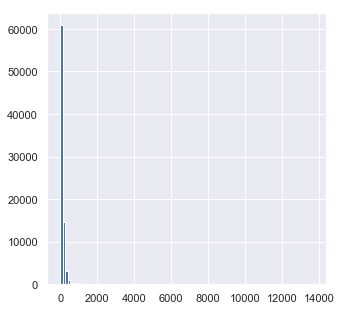

In [8]:
# distrbution of prices
listings_df['price'].hist(bins=100);



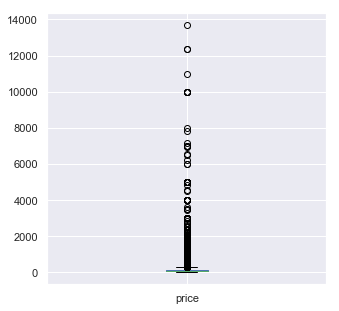

In [9]:
# box plot of prices
boxplot = listings_df.boxplot(column=['price'])



(array([8.0623e+04, 8.7000e+01, 2.1000e+01, 1.5000e+01, 5.0000e+00,
        7.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([    0.,  1370.,  2740.,  4110.,  5480.,  6850.,  8220.,  9590.,
        10960., 12330., 13700.]),
 <a list of 10 Patch objects>)

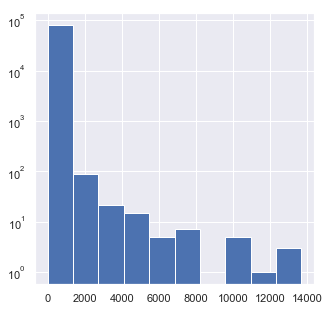

In [10]:
# distrbution of prices in log transform
plt.hist(listings_df['price'], log=True) 




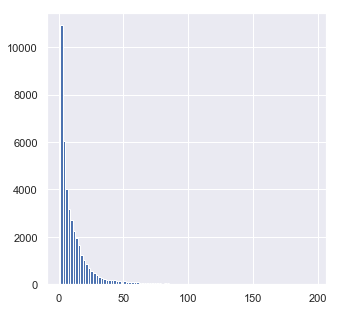

In [11]:
# distrbution of dates
reviews_df['date'].hist(bins=100);



In [12]:
# describe of dates
reviews_df['date'].describe()




count    41188.000000
mean        11.349034
std         14.649154
min          1.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        197.000000
Name: date, dtype: float64

### Prepare Data


Here we will filter out dates just to 2018. Then we will group by the individual listing ids (the respective unique properties) and count the number of times the listing was used in 2018. Once we have manipulated the review file to be aggregated to one line per entry in the listing files we can join them.

In [4]:
# filter dates 

start_date = '2018-01-01'
end_date = '2018-12-31'
mask = (reviews_df['date'] > start_date) & (reviews_df['date'] <= end_date)
reviews_df = reviews_df.loc[mask]
reviews_df = reviews_df.groupby('listing_id').count()
reviews_df.head()


,date
listing_id,
11551,7
13913,3
15400,3
17402,14
25023,6


In [13]:
# merge listings and reviews
df = pd.merge(listings_df, reviews_df, left_on='id', right_on='listing_id')
df.head()




,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date
0,11551,Stylish and bright London apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290,7
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362,3
2,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,84,2019-04-22,0.74,1,155,3
3,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,40,2019-04-20,0.40,13,230,14
4,25023,All-comforts 2-bed flat near Wimbledon tennis,102813,Amanda,NaN,Wandsworth,51.44687,-0.21874,Entire home/apt,65,4,27,2019-03-11,0.70,1,9,6


In [14]:
# check each id is unique - one row per id
print(len(df['id'].unique().tolist()))
print(df['id'].count())




41188
41188


In [15]:
# describe merged dfs
 
print(df.describe())




                 id       host_id  neighbourhood_group      latitude  \
count  4.118800e+04  4.118800e+04                  0.0  41188.000000   
mean   1.867687e+07  6.576282e+07                  NaN     51.509152   
std    8.465046e+06  6.563704e+07                  NaN      0.044945   
min    1.155100e+04  2.010000e+03                  NaN     51.294790   
25%    1.329791e+07  1.117368e+07                  NaN     51.486200   
50%    2.067337e+07  3.795253e+07                  NaN     51.513710   
75%    2.540276e+07  1.129129e+08                  NaN     51.535420   
max    3.120145e+07  2.416394e+08                  NaN     51.679200   

          longitude         price  minimum_nights  number_of_reviews  \
count  41188.000000  41188.000000    41188.000000       41188.000000   
mean      -0.129145    105.924565        4.025833          28.845076   
std        0.090371    150.092166       25.444193          43.535392   
min       -0.496960      0.000000        1.000000           1.0

In [16]:
# Percentage of dates compared to availablity
def check_dates(df):
    """
    This function checks if the number of dates the property was 
    used went over the availability. If so then it changes the availability 
    of the property to 365.
    Args:
    - df (pandas dataframe)
    Return:
    - returns column availability_365 results 
    """
    if (df['date'] > df['availability_365'] ):
        return 365
    elif (df['date'] <= df['availability_365'] ):
        return df['availability_365'] 

df = df[(df[['availability_365']] != 0).all(axis=1)]
df['availability_365'] = df.apply(check_dates, axis = 1)

df['useage'] = df['date']/df['availability_365'] * 100
df['useage'].head()








0     2.413793
1     0.828729
2     1.935484
3     6.086957
4    66.666667
Name: useage, dtype: float64

In [17]:
# describe useage of properties

print(df.useage.describe())

print('--------------')
print('NANs in df')
print(df.isna().sum())

print('--------------')
print('mean of usage')
print(df.useage.mean())

print('--------------')
print('median of usage')
print(df.useage.median())





count    31643.000000
mean        12.712029
std         18.691557
min          0.273973
25%          1.818182
50%          5.263158
75%         14.516129
max        100.000000
Name: useage, dtype: float64
--------------
NANs in df
id                                    0
name                                  0
host_id                               0
host_name                            18
neighbourhood_group               31643
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
date                                  0
useage                                0
dtype: int64
--------------
mean of usage
12.7120

35363342.0
count     31643.000000
mean       1117.572354
std        2062.146941
min           0.000000
25%         220.500000
50%         600.000000
75%        1440.000000
max      223040.000000
Name: income, dtype: float64


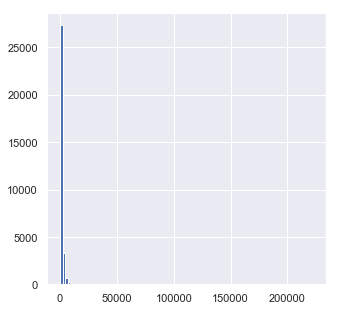

In [18]:
# How much income was generated 
df['income'] = df['price'] * df['useage']/100 * df['availability_365']
print(df['income'].sum())

df['income'].hist(bins=100);
print(df['income'].describe())



### Data Modeling


Next we will try to curve fit the results from the usage histogram with a simulated distribution of our own. 

4.848484848484849


C:\Users\Jared\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

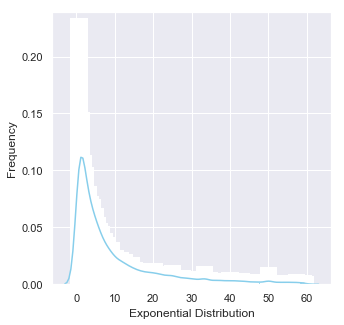

In [19]:
# distrbution of useage
#df['useage'].hist(bins=100);
data =  df[df['useage'] < 60]
print(df[df['useage'] < 60].useage.median())
ax = sns.distplot(data['useage'],
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Exponential Distribution', ylabel='Frequency')




[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

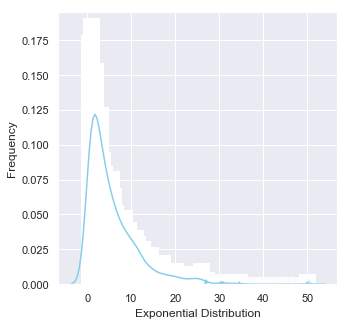

In [20]:
# fitting a expontial distrbution to useage
data_expon = expon.rvs(scale=5.5, loc=0, size=1000)
ax = sns.distplot(data_expon,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Exponential Distribution', ylabel='Frequency')



[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

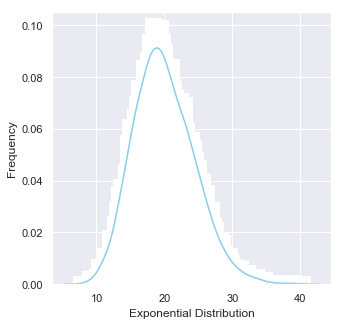

In [21]:
# fitting a gamma distrbution to useage
data_gamma = gamma.rvs(a=20, size=10000)
ax = sns.distplot(data_gamma,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Exponential Distribution', ylabel='Frequency')





In [22]:
# monte-carlo simulation functions
def get_rand_numbers(scale=5, size=1000):
    """
    This function generates a random number from a gamma distribution
    Return:
    - Random number (float)
    """
    roll = expon.rvs(scale=scale, loc=0, size=size)
    roll = roll/100
    return roll

def monte_carlo_sim(df, scale =4.9, number_sim = 100):
    """
    This function generates a monte-carlo simulation to determine the distribution of 
    overall incomes which are possible given a specific dataframe
    and gamma distribution
    Return:
    - final_income (array of int) each value represents the sum of the income from that simulation
    """
    x = 0
    final_income = []
    while x < number_sim:  
        sim_outputs = df['price'] * df['availability_365']
        y = np.array(get_rand_numbers(scale = scale, size=sim_outputs.shape[0]))
        income_iter = sum(sim_outputs.multiply(y, axis=0))	
        final_income.append(income_iter)
        x+=1 # increase the count
    return final_income



### Evaluate the Results

Lastly we will evaluate our curve that we fitted earlier using monte-carlos simulations against the true estimates of the actual income earned from the listings (the red line in the plot below), compared against a 100k simulations. In the results we can see how much Airbnb's London listing earned ~£35.5M compared to the simulated results, that do seem to fit around the mean of the actual results. 

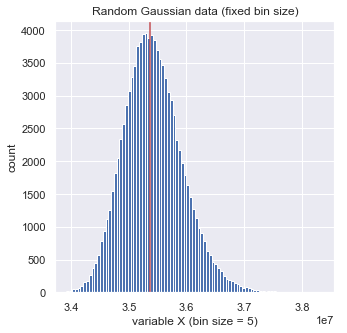

In [23]:
# monte-carlo simulation of income generated
def plot_simulation(df, scale = 5.2, number_sim = 1000):
    """
    This function generates a monte-carlo simulation to determine the distribution of 
    overall incomes which are possible given a specific dataframe
    and gamma distribution
    Return:
    - final_income (array of int) each value represents the sum of the income from that simulation
    """
    sim_outputs = monte_carlo_sim(df=df, scale=scale, number_sim = number_sim)
    data = array(sim_outputs)
    plt.xlim([min(data), max(data)])
    plt.hist(data, bins=100)
    plt.title('Random Gaussian data (fixed bin size)')
    plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')
    plt.axvline(df['income'].sum(), color='r')
    plt.show()



plot_simulation(df , scale = 5.2, number_sim = 100000)

